In [1]:
# enabling 3rd party widgets
# from google.colab import output
# output.enable_custom_widget_manager()
# output.disable_custom_widget_manager()

# interactive 3D plot
# !pip install ipympl
# %matplotlib widget

In [2]:
import os
import math
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

import time as time
import platform as platform

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import L2
import h5py

In [3]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/Thesis/CDV/')
print(os.getcwd())

/content/drive/MyDrive/Colab Notebooks/Thesis/CDV


In [6]:
from tools.misc_tools import create_CDV_data, create_data_for_RNN, mytimecallback, SaveLosses, plot_losses, plot_reconstructed_data_cdv, plot_latent_states_cdv, readAndReturnLossHistories, sigmoidWarmupAndDecayLRSchedule
from tools.ae_v3 import Autoencoder
from tools.LSTM_AR_v2 import AR_RNN_LSTM as RNN_LSTM

In [7]:
prng_seed = 42
np.random.seed(prng_seed)
tf.random.set_seed(prng_seed)

#CDV

In [8]:
params_mat = np.array([
    [0.95, -0.76095, 0.1, 1.25, 0.2, 0.5],
    [0.99, -0.801*0.99, 0.1, 1.25, 0.2, 0.5]
])

init_state = [-1]*6

t0 = 0.0
T = 1500.0
delta_t = 0.01

return_params_arr = False
normalize_flag = False

In [9]:
res_dict = create_CDV_data(
    T, t0, delta_t,
    params_mat,
    init_state, return_params_arr=return_params_arr,
    normalize=normalize_flag
)

all_data = res_dict['all_data']
N = res_dict['N']
boundary_idx_arr = res_dict['boundary_idx_arr']

if return_params_arr == True:
    params_arr = res_dict['params_arr']

if normalize_flag == True:
    normalization_constant_arr = res_dict['normalization_constant_arr']

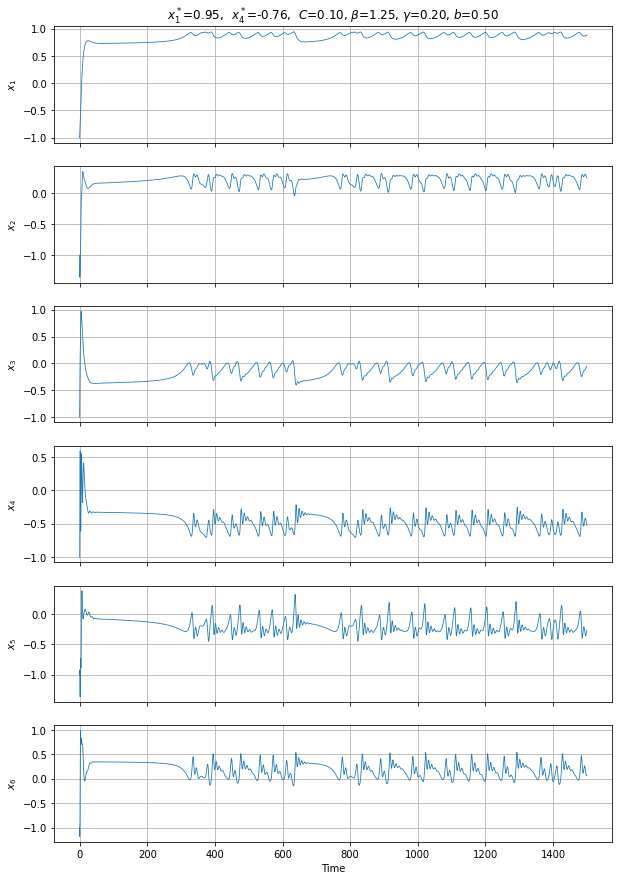

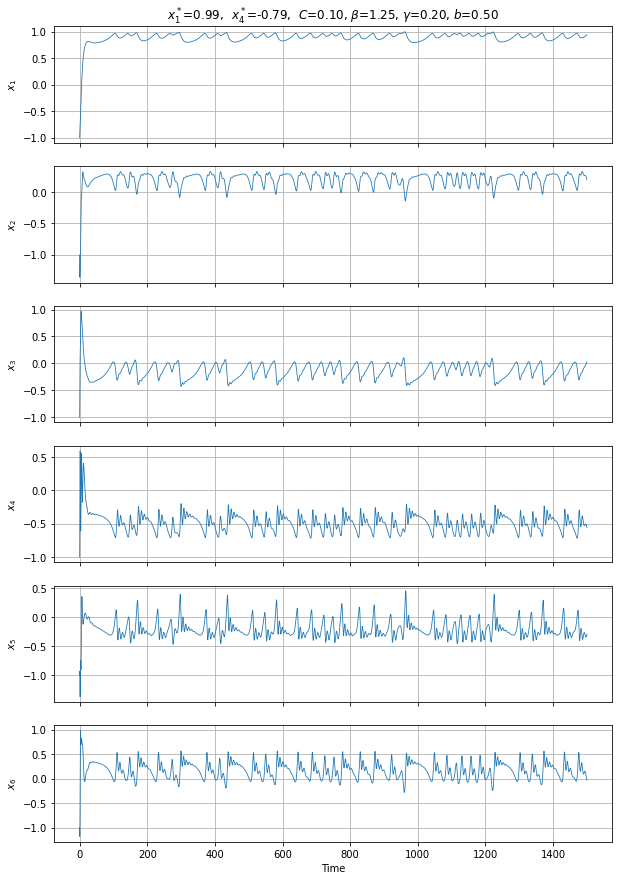

In [10]:
n = len(boundary_idx_arr)
# '''
num_cols = 1
num_rows = 6

factor = 1

prev_idx = 0
for i in range(len(boundary_idx_arr)):
    fig, ax = plt.subplots(6, 1, sharex=True, figsize=(factor*10*num_cols, factor*2.5*num_rows))
    ax_ylabels = ['$x_1$', '$x_2$', '$x_3$', '$x_4$', '$x_5$', '$x_6$']
    input_time = np.arange(0, N+1)*delta_t
    for j in range(6):
        ax[j].plot(input_time, all_data[i*(N+1):(i+1)*(N+1), j], linewidth=0.8)#, label='_nolegend_')
        ax[j].grid()
        ax[j].set_ylabel(ax_ylabels[j])
        
    # fig.suptitle(r'$x_1^*$={:.2f},  $x_4^*$={:.2f},  $C$={:.2f}, $\beta$={:.2f}, $\gamma$={:.2f}, $b$={:.2f}'.format(
    #     all_data[i*(N+1), 6],
    #     all_data[i*(N+1), 7],
    #     all_data[i*(N+1), 8],
    #     all_data[i*(N+1), 9],
    #     all_data[i*(N+1), 10],
    #     all_data[i*(N+1), 11]
    # ))
    ax[0].set_title(r'$x_1^*$={:.2f},  $x_4^*$={:.2f},  $C$={:.2f}, $\beta$={:.2f}, $\gamma$={:.2f}, $b$={:.2f}'.format(
        all_data[i*(N+1), 6],
        all_data[i*(N+1), 7],
        all_data[i*(N+1), 8],
        all_data[i*(N+1), 9],
        all_data[i*(N+1), 10],
        all_data[i*(N+1), 11]
    ), size=12)
    ax[-1].set_xlabel('Time')
    plt.show()
    print('')
# '''

In [17]:
cutoff_times = np.array([
    400,
    200
])

cutoff_idxs = np.array([int((tt+0.25*delta_t)//delta_t) for tt in cutoff_times])

temp = np.empty(shape=len(boundary_idx_arr), dtype=np.int32)
temp[0] = 0
temp[1:] = boundary_idx_arr[:-1]
initial_x0 = all_data[temp + cutoff_idxs, :]

In [19]:
initial_x0

array([[ 0.8453417 ,  0.24575967, -0.23553927, -0.5026474 , -0.20420438,
         0.19842753,  0.95      , -0.76095   ,  0.1       ,  1.25      ,
         0.2       ,  0.5       ],
       [ 0.8472098 ,  0.29846168, -0.1935233 , -0.40700465, -0.2731607 ,
         0.25635102,  0.99      , -0.79299   ,  0.1       ,  1.25      ,
         0.2       ,  0.5       ]], dtype=float32)